# Figures and finished data processing for Si from sparse and patchy data paper


In [177]:
from Ge_calculation import GAP, MD_run
from Ge_analysis import *
import pickle
from ase.io.cfg import read_cfg
import numpy as np
import os
from ase import build
from ase.atoms import Atoms
from quippy.potential import Potential
from quippy.descriptors import Descriptor
from copy import deepcopy
from ase.io.extxyz import read_xyz, write_xyz
import pandas as pd
from sklearn import decomposition
import matplotlib.pyplot as plt
from glob import glob

import numpy as np

from scipy.stats import gaussian_kde

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from ase.io import read, write
from ase.neighborlist import neighbor_list

from collections import Counter

from quippy.descriptors import Descriptor

from matscipy.rings import ring_statistics

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [ 'Helvetica', 'Arial', 'FreeSans', 'DejaVu Sans' ]

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['legend.borderaxespad'] = 1.5

plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 1.5

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.0

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.0


In [114]:
os.chdir('/home/joe/Documents/Ge_od/Si_JCP_data')

# Validation of the GAP fitting
* RMS on a testing set, choose the GAP-18 database's liquid/amorphous/crystalline structures (separately)

## Regularisation

In [3]:
reg_DIR = '/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing/'
red_DIR = '/home/joe/Documents/Ge_od/Potentials/Si_myDB_reduction_testing/'

In [4]:
with open('/home/joe/Documents/Ge_od/Structure_databases/gp_iter6_sparse9k.xml.xyz', 'r') as f:
    GAP_6 = list(read_xyz(f, index=slice(0,None)))
with open('/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing/Si_myDB_64_125_216_train.xyz', 'r') as f:
    MyDB_liqamo_train = list(read_xyz(f, index=slice(0,None)))
with open('/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing/Si_myDB_64_125_216_validate.xyz', 'r') as f:
    MyDB_liqamo_val = list(read_xyz(f, index=slice(0,None)))

Plots here of:

Structure factor FSP alongside RMSE (test set and *ab initio* MD for both MTP and GAP):
* regularisation increasing from normal to very loose (GAP only)
* DB reduction from 100% to 25%

ensure test set is 20% portion of GAP-MD data, strictly totally separate runs (not correlated)

systematic reduction: be *more* systematic, removing particular runs?

### Calculate RMSEs

In [34]:
MY_GAPs_reg_paths =  sorted([i for i in glob(os.path.join(reg_DIR, 'Si_myDB_ds*xml'))])
print(MY_GAPs_reg_paths)
MY_GAPs_reg_paths[0] = '/home/joe/Documents/Ge_od/Potentials/Si_myDB_216/Si_myDB_64_125_216.xml' # default_sigma={0.001 0.1 0.05 0.0}
MY_GAPs_reg = [Potential(param_filename=i) for i in MY_GAPs_reg_paths]

['/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing/Si_myDB_ds0.001_0.5_0.05_0.0.xml', '/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing/Si_myDB_ds0.025_0.25_0.125_0.0.xml', '/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing/Si_myDB_ds0.075_0.75_0.375_0.0.xml', '/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing/Si_myDB_ds0.1_1.0_0.5_0.0.xml']


/home/joe/ase/ase/calculators/calculator.py:507: FutureWarning: The keyword "ignore_bad_restart_file" is deprecated and will be removed in a future version of ASE.  Passing more than one positional argument to Calculator is also deprecated and will stop functioning in the future.  Please pass arguments by keyword (key=value) except optionally the "restart" keyword.
  warnings.warn(FutureWarning(


In [ ]:
reg_RMS_data = [[[], [], []] for i in MY_GAPs_reg]
for i, val in enumerate(MY_GAPs_reg):
    for j in GAP_6:
        val.calculate(j, properties=['energies', 'forces', 'stress'])
        reg_RMS_data[i][0].append(val.results['energy']/len(j))
        reg_RMS_data[i][1].append(val.results['forces'])
        reg_RMS_data[i][2].append(val.results['virial'])
    print('pot {} done'.format(i))

In [25]:
# for i, val in enumerate(MY_GAPs_reg):
#     for j, val2 in enumerate(GAP_6):
#         reg_RMS_data[i][0][j] *= 1/len(val2)

In [35]:
reg_RMS_data_my = [[[], [], []] for i in MY_GAPs_reg]
for i, val in enumerate(MY_GAPs_reg):
    for j in MyDB_liqamo_val:
        val.calculate(j, properties=['energies', 'forces', 'stress'])
        reg_RMS_data_my[i][0].append(val.results['energy']/len(j))
        reg_RMS_data_my[i][1].append(val.results['forces'])
        reg_RMS_data_my[i][2].append(val.results['virial'])
    print('pot {} done'.format(i))

pot 0 done
pot 1 done
pot 2 done
pot 3 done


In [36]:
with open('tmp_save.pickle', 'wb') as f:
    pickle.dump([reg_RMS_data, reg_RMS_data_my], f)

In [6]:
with open('tmp_save.pickle', 'rb') as f:
    reg_RMS_data, reg_RMS_data_my = pickle.load(f)

In [37]:
MyDB_liqamo_val_E = np.array([i.info['dft_energy']/len(i) for i in MyDB_liqamo_val])

In [38]:
MyDB_liqamo_val_F = np.array(flatten([i.arrays['dft_forces'].flatten() for i in MyDB_liqamo_val]))

In [39]:
E_rmses_reg = [rms_dict(np.array(i[0]), MyDB_liqamo_val_E) for i in reg_RMS_data_my]

In [52]:
reg_RMS_data_my_F_flat = [np.array(flatten(flatten(i[1]))) for i in reg_RMS_data_my]

In [40]:
F_rmses_reg = [rms_dict(i, MyDB_liqamo_val_F) for i in reg_RMS_data_my_F_flat]

In [41]:
F_rmses_reg

[{'rmse': 0.1929440870407516, 'std': 0.05730850114780417},
 {'rmse': 0.18820631171077046, 'std': 0.056123225105518884},
 {'rmse': 0.2222674459109712, 'std': 0.08380907007687935},
 {'rmse': 0.23599597411051107, 'std': 0.0976601124896513}]

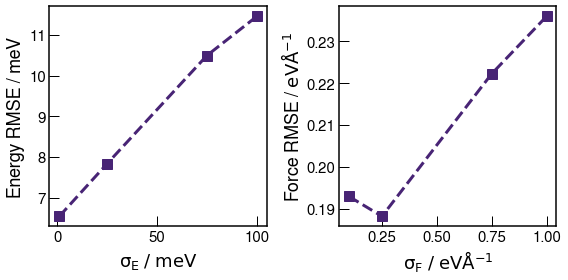

In [199]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
E_reg = np.array([0.001, 0.025, 0.075, 0.1])*1000
F_reg = [0.1, 0.25, 0.75, 1.0]
# axs.errorbar(reg, [i['rmse'] for i in E_rmses_reg], yerr=[i['std'] for i in E_rmses_reg])
axs[0].errorbar(E_reg, np.array([i['rmse'] for i in E_rmses_reg])*1000,
                yerr=None, fmt='s--', color=colors[0], markersize=10)
axs[0].set(xlabel='$\mathrm{\sigma_E \; / \; meV}$', ylabel='Energy RMSE / meV')

axs[1].errorbar(F_reg, [i['rmse'] for i in F_rmses_reg],
                yerr=None, fmt='s--', color=colors[0], markersize=10)
axs[1].set(xlabel='$\mathrm{\sigma_F \; / \; eV\AA^{-1}}$', ylabel='Force RMSE / $\mathrm{eV\AA^{-1}}$')

axs[0].tick_params(axis="both",direction="in", left="off",labelleft="on")
axs[1].tick_params(axis="both",direction="in", left="off",labelleft="on")
axs[0].xaxis.labelpad = 7
# axs[1].xaxis.labelpad = 20
plt.tight_layout()
fig.savefig('temp_figs/reg_RMSE.png', dpi=100, bbox_inches='tight')

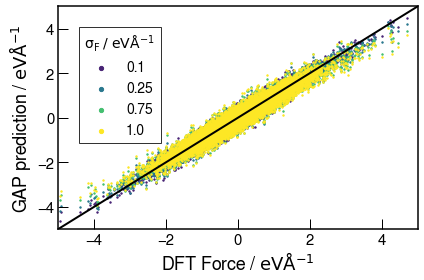

In [192]:
fig, axs = plt.subplots()
colormap = plt.get_cmap('viridis')
colors = [colormap(i) for i in np.linspace(F_reg[0], F_reg[-1], len(F_reg))]
for i, val in enumerate(reg_RMS_data_my_F_flat):
    axs.scatter(MyDB_liqamo_val_F, val, s=2, label=F_reg[i], color=colors[i])
# axs.plot(x:=np.linspace(-168.8,-168.0), x, color='k', linewidth=0.5)
axs.plot(x:=np.linspace(-5,5), x, color='k', linewidth=2)
axs.set(xlim=(-5,5), ylim=(-5,5))
axs.legend(title='$\mathrm{\sigma_F \; / \; eV\AA^{-1}}$', markerscale=3)
axs.set(xlabel='DFT Force / $\mathrm{eV\AA^{-1}}$', ylabel='GAP prediction / $\mathrm{eV\AA^{-1}}$')
axs.tick_params(axis="both",direction="in", left="off",labelleft="on")
plt.tight_layout()
fig.savefig('temp_figs/reg_Force.png', dpi=100, bbox_inches='tight')

### MD runs

In [76]:
MD_reg_dir = '/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing'
MD_64dirs_pre = [i for i in os.listdir(MD_reg_dir) if 'run_64' in i]
selection = [1, 2, 4]
MD_64dirs = [os.path.join(MD_reg_dir, MD_64dirs_pre[i]) for i in selection] + ['/home/joe/Documents/Ge_od/Potentials/Si_myDB_216/run_64_loose']
MD_64dirs

['/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing/run_64_Si_myDB_ds0.001_0.5_0.05_0.0',
 '/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing/run_64_Si_myDB_ds0.025_0.25_0.125_0.0',
 '/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing/run_64_Si_myDB_ds0.075_0.75_0.375_0.0',
 '/home/joe/Documents/Ge_od/Potentials/Si_myDB_216/run_64_loose']

In [77]:
reg_run_64s = [MD_run(i, label=i.split('/')[-1][15:]) for i in MD_64dirs]

### Coordination stats

In [82]:
cns = np.array([cn_count(i.df['Configs'][240000])[1] for i in reg_run_64s])

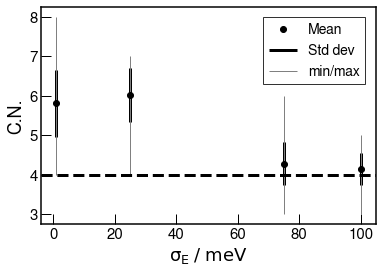

In [193]:
mins = cns.min(1)
maxs = cns.max(1)
means = cns.mean(1)
std = cns.std(1)

fig, axs = plt.subplots()
l1 = axs.errorbar(E_reg, means, std, fmt='ok', lw=3)
l2 = axs.errorbar(E_reg, means, [means - mins, maxs - means],
             fmt='.k', ecolor='gray', lw=1)
axs.axhline(4, color='k', linestyle='--')
# axs.table(cellText=np.array([np.arange(n), [i.label for i in reg_run_64s]]).T,
#           edges='', loc=14, colWidths=[0.1,0.5])
axs.set(xlabel='$\mathrm{\sigma_E \; / \; meV}$', ylabel='C.N.')
axs.legend([l1[0], l1[2], l2[2]], ('Mean', 'Std dev', 'min/max'), bbox_to_anchor=(1.03, 1.05))
fig.savefig('temp_figs/reg_CN.png', dpi=100, bbox_inches='tight')

## Ring stats

In [241]:
rs = [ring_statistics(i.df['Configs'][240000], cutoff=2.7) for i in reg_run_64s]
max = 0
for i in rs:
    if max < len(i):
        max = len(i)
max += 2

for ct, i in enumerate(rs):
    if len(i) < max:
        rs[ct] = np.pad(i, (0, max - len(i)))
    print(rs[ct])
rs = np.array(rs)

[ 0  0  0 20 35 53 51 19  0  0  0]
[ 0  0  0 18 81 58 81 10  0  0  0]
[ 0  0  0  6  4 24 67 20  2  0  0]
[ 0  0  0  5  2 26 56 42  2  0  0]


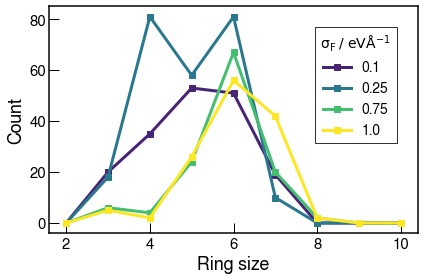

In [248]:
fig, axs = plt.subplots()
colormap = plt.get_cmap('viridis')
colors = [colormap(i) for i in np.linspace(F_reg[0], F_reg[-1], len(F_reg))]
for i, val in enumerate(rs):
    axs.plot(np.arange(2, len(rs[0])), val[2:], label=F_reg[i],
             color=colors[i], marker='s')
# axs.set(xlim=(2,11), ylim=(-5,5))
axs.legend()
axs.set(xlabel='Ring size', ylabel='Count')
axs.tick_params(axis="both",direction="in", left="off",labelleft="on")
axs.legend(title='$\mathrm{\sigma_F \; / \; eV\AA^{-1}}$')
plt.tight_layout()
fig.savefig('temp_figs/reg_rings.png', dpi=100, bbox_inches='tight')

In [ ]:
test = Atoms('Si3', positions=[(1,0,0), (0,1,0), (0,0,1)], cell=[10,10,10], pbc=[1,1,1])
ring_statistics(test, cutoff=2.7)

### Diffraction

In [89]:
for ct, i in enumerate(reg_run_64s):
    i.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='Regularisation/Sq_'+i.label,
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=False)

    i.bin_fit(s_selection=[i for i in range(90)], q_selection=[0.5,12])
    i.bin_fit(s_selection=[i for i in range(90, 110)], q_selection=[0.5,12])

R.I.N.G.S ran successfully


FileNotFoundError: [Errno 2] No such file or directory: 'ring.log'

In [ ]:
fig, axs = plt.subplots()
for i in reg_run_64s:
    axs.errorbar(*i.Sq_x_av[1], yerr=None,
                label=i.label)
axs.plot(*aSi_exp_Sq, color='Gray', linewidth=2, label='Exp. a-Si')
axs.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
axs.set(xlim=(1,12))

## Reduction of the DB: GAP and MTPs

## Generalisation to crystals: GAP vs. MTP (with and without crystal structures in database?)


